In [1]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from scipy.stats import uniform, randint
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit 
import optuna
from optuna.integration import XGBoostPruningCallback
import shap


c:\Users\davic\anaconda3\envs\pythree\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Load dataset from Google Drive
df = pd.read_csv('smart_data.csv')
display(df.head())

,Unnamed: 0,Timestamp,Hour of Day,Day of Week,Is Weekend,Season,Month,Historical Electricity Load (kW),Solar PV Output (kW),Wind Power Output (kW),...,Renewable Forecast Error,Curtailment Event Flag,Temperature (°C),Humidity (%),Solar Irradiance (W/m²),Cloud Cover (%),Atmospheric Pressure (hPa),Electricity Load,Curtailment Risk / Surplus Flag,Net Load
0,0,2021-01-01 00:00:00+00:00,0,4,0,1,1,192.976646,26.711357,89.955936,...,1.561315,0,27.751690,26.752728,298.548493,66.808656,1016.729989,209.578166,0,92.910873
1,1,2021-01-01 00:30:00+00:00,0,4,0,2,1,709.417292,9.158357,31.444883,...,-7.721824,1,36.734599,5.300440,18.781034,41.478383,1016.800076,711.329436,0,670.726196
2,2,2021-01-01 01:00:00+00:00,1,4,0,2,1,441.323762,28.972804,16.262761,...,19.499594,0,9.081235,39.869765,73.679871,58.029436,1026.064324,434.571941,0,389.336376
3,3,2021-01-01 01:30:00+00:00,1,4,0,1,1,110.061053,50.747398,165.385627,...,-31.022738,0,8.856865,24.710236,110.349077,61.016343,1012.320187,119.913430,1,-96.219595
4,4,2021-01-01 02:00:00+00:00,2,4,0,2,1,741.130717,12.410062,308.199156,...,8.562387,0,13.782261,12.330477,605.363264,26.748752,1018.686435,747.746618,0,427.137399


In [8]:
# Transform dataframe into datetime series
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72960 entries, 2021-01-01 00:00:00+00:00 to 2025-02-28 23:30:00+00:00
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         72960 non-null  int64  
 1   Hour of Day                        72960 non-null  int64  
 2   Day of Week                        72960 non-null  int64  
 3   Is Weekend                         72960 non-null  int64  
 4   Season                             72960 non-null  int64  
 5   Month                              72960 non-null  int64  
 6   Historical Electricity Load (kW)   72960 non-null  float64
 7   Solar PV Output (kW)               72960 non-null  float64
 8   Wind Power Output (kW)             72960 non-null  float64
 9   Wind Speed (m/s)                   72960 non-null  float64
 10  Battery State of Charge (SOC) (%)  72960 non-null  float64
 11  Renewab

In [9]:
# Drop column 
df = df.drop('Unnamed: 0', axis = 1) 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72960 entries, 2021-01-01 00:00:00+00:00 to 2025-02-28 23:30:00+00:00
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Hour of Day                        72960 non-null  int64  
 1   Day of Week                        72960 non-null  int64  
 2   Is Weekend                         72960 non-null  int64  
 3   Season                             72960 non-null  int64  
 4   Month                              72960 non-null  int64  
 5   Historical Electricity Load (kW)   72960 non-null  float64
 6   Solar PV Output (kW)               72960 non-null  float64
 7   Wind Power Output (kW)             72960 non-null  float64
 8   Wind Speed (m/s)                   72960 non-null  float64
 9   Battery State of Charge (SOC) (%)  72960 non-null  float64
 10  Renewable Forecast Error           72960 non-null  float64
 11  Curtail

In [ ]:
# Set Categorical Columns
# df['Hour of Day'] = df['Hour of Day'].astype('category') 
# df['Day of Week'] = df['Day of Week'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72960 entries, 2021-01-01 00:00:00+00:00 to 2025-02-28 23:30:00+00:00
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Hour of Day                        72960 non-null  category
 1   Day of Week                        72960 non-null  category
 2   Is Weekend                         72960 non-null  int64   
 3   Season                             72960 non-null  int64   
 4   Month                              72960 non-null  int64   
 5   Historical Electricity Load (kW)   72960 non-null  float64 
 6   Solar PV Output (kW)               72960 non-null  float64 
 7   Wind Power Output (kW)             72960 non-null  float64 
 8   Wind Speed (m/s)                   72960 non-null  float64 
 9   Battery State of Charge (SOC) (%)  72960 non-null  float64 
 10  Renewable Forecast Error           72960 non-null  float64 

In [11]:
# Function for lag colums
# Create Lag Columns
lag_cols = [
    'Solar PV Output (kW)', 'Wind Power Output (kW)', 'Wind Speed (m/s)',
    'Battery State of Charge (SOC) (%)', 'Renewable Forecast Error',
    'Curtailment Event Flag', 'Temperature (°C)', 'Humidity (%)',
    'Solar Irradiance (W/m²)', 'Cloud Cover (%)',
    'Atmospheric Pressure (hPa)', 'Curtailment Risk / Surplus Flag',
    'Net Load'
    ]

# Define Lag durations
lags = [1, 2, 3, 48, 96, 336]

# Function
def create_lag_features(df, columns, lags):
    """
    Create lag features for multiple columns.

    Parameters:
    df (pd.DataFrame): Input dataframe
    columns (list): List of column names to create lags for
    lags (list): List of integer lag values (e.g., [1, 2, 48])

    Returns:
    pd.DataFrame: Dataframe with lag features added
    """
    df = df.copy()

    for col in lag_cols:
        # Create lag features
        for lag in lags:
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)

    return df

In [12]:
# Run Function
df = create_lag_features(df, lag_cols, lags)
df = df.dropna()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72624 entries, 2021-01-08 00:00:00+00:00 to 2025-02-28 23:30:00+00:00
Data columns (total 98 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Hour of Day                                72624 non-null  int64  
 1   Day of Week                                72624 non-null  int64  
 2   Is Weekend                                 72624 non-null  int64  
 3   Season                                     72624 non-null  int64  
 4   Month                                      72624 non-null  int64  
 5   Historical Electricity Load (kW)           72624 non-null  float64
 6   Solar PV Output (kW)                       72624 non-null  float64
 7   Wind Power Output (kW)                     72624 non-null  float64
 8   Wind Speed (m/s)                           72624 non-null  float64
 9   Battery State of Charge (SOC) (%)          7262

In [13]:
# Function For Rolling Windows
# Define columns for rolling windows
win_cols = [
    'Solar PV Output (kW)', 'Wind Power Output (kW)', 'Wind Speed (m/s)',
    'Battery State of Charge (SOC) (%)', 'Renewable Forecast Error',
    'Temperature (°C)', 'Humidity (%)', 'Solar Irradiance (W/m²)',
    'Cloud Cover (%)', 'Atmospheric Pressure (hPa)',
    'Net Load'
    ]

# Define Window Sizes
windows = [3, 6, 12, 48]

# Stats for rolling windows
stats=['mean','std','min','max']

# Function
def create_window_features(df, columns, windows):
    """
    Create window features for multiple columns.

    Parameters:
    df (pd.DataFrame): Input dataframe
    columns (list): List of column names to create lags for
    lags (list): List of integer lag values (e.g., [1, 2, 48])

    Returns:
    pd.DataFrame: Dataframe with lag features added
    """
    df = df.copy()

    for col in win_cols:
        # Create window features
        for w in windows:
          for stat in stats:
            df[f"{col}_rw_{stat}"] = df[col].rolling(w).agg(stat)

    return df

In [ ]:
# New Target Encoding logic added to the notebook
# def perform_target_encoding(df, target_col, cat_cols):
#     df = df.copy()
#     for col in cat_cols:
#         mapping = df.groupby(col)[target_col].mean()
#         df[f"{col}_encoded"] = df[col].map(mapping)
#     return df

In [37]:
# Run Fuction
df = create_window_features(df, win_cols, windows)
df = df.dropna()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72577 entries, 2021-01-08 23:30:00+00:00 to 2025-02-28 23:30:00+00:00
Columns: 142 entries, Hour of Day to Net Load_rw_max
dtypes: category(2), float64(135), int64(5)
memory usage: 78.2 MB
None


In [38]:
# Peak Hour
# Create 'IsPeakHour' - 7 AM to 10 PM
df['IsPeakHour'] = ((
    df['Hour of Day'] >= 7) & (df['Hour of Day'] < 22)).astype(int)

# Create the interaction feature by multiplying Temperature by IsPeakHour
df['Temp_pkhr'] = df[
    'Temperature (°C)'] * df['IsPeakHour']

print(df.info())

TypeError: Unordered Categoricals can only compare equality or not

In [ ]:
# Feature 2 - Season and temperature

# Get Summer months (e.g., June, July, August)
df['IsSummer'] = ((
    df['Month'] >= 6) & (df['Month'] <= 8)).astype(int)

# Get Winter months (e.g., December, January, February)
df['IsWinter'] = ((
    df['Month'] == 12) | (df['Month'] <= 2)).astype(int)

# Create the interaction features
# This captures the heating load in winter as temperature drops
df['Temp_x_Win'] = df['Temperature (°C)'] * df['IsWinter']

# This captures the cooling load in summer as temperature rises
df['Temp_x_Sum'] = df['Temperature (°C)'] * df['IsSummer']

print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72910 entries, 2021-01-02 01:00:00+00:00 to 2025-02-28 23:30:00+00:00
Columns: 109 entries, Hour of Day to Temp_x_Sum
dtypes: float64(99), int64(10)
memory usage: 61.2 MB
None


In [ ]:
# Transform, Day, Week and Month into Cyclical Features
# Set number of periods in a day
period_hour = 24

# Get Sine and Cosine values
df['hr_sin'] = np.sin(
    2 * np.pi * df['Hour of Day'] / period_hour)
df['hr_cos'] = np.cos(
    2 * np.pi * df['Hour of Day'] / period_hour)

# Set number of periods in a week
period_week = 7

# Get cyclical features
df['wk_sin'] = np.sin(
    2 * np.pi * df['Day of Week'] / period_week)
df['wk_cos'] = np.cos(
    2 * np.pi * df['Day of Week'] / period_week)

# No of periods in a month
period_month=12

# Get Cyclical Features
df['mo_sin'] = np.sin(2 * np.pi * df['Month'] / period_month)
df['mo_cos'] = np.cos(2 * np.pi * df['Month'] / period_month)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72910 entries, 2021-01-02 01:00:00+00:00 to 2025-02-28 23:30:00+00:00
Columns: 115 entries, Hour of Day to mo_cos
dtypes: float64(105), int64(10)
memory usage: 64.5 MB
None


In [ ]:
# Get first record start date
print(df.index[0])

#Get last date
print(df.index[-1])

# Len of df
print(len(df))

2021-01-02 01:00:00+00:00
2025-02-28 23:30:00+00:00
72910


In [ ]:
# Define Target Variable before split
df['4hr_load'] = df['Net Load'].shift(-8)
df = df.dropna()

In [ ]:
# Check the last columns 
print(df.iloc[:, -1])

Timestamp
2021-01-02 01:00:00+00:00    426.937403
2021-01-02 01:30:00+00:00    476.691519
2021-01-02 02:00:00+00:00    377.117856
2021-01-02 02:30:00+00:00    305.797245
2021-01-02 03:00:00+00:00    316.840309
                                ...    
2025-02-28 17:30:00+00:00    939.876490
2025-02-28 18:00:00+00:00    551.538118
2025-02-28 18:30:00+00:00    197.480398
2025-02-28 19:00:00+00:00    291.661479
2025-02-28 19:30:00+00:00    268.835947
Name: 4hr_load, Length: 72902, dtype: float64


In [ ]:
# Train. Test & Validation Splits

# Train Split 2021 - 2023
train_df = df.loc['2021-01-16 05:30':'2023-12-23 23:30']
X_train, y_train = train_df.iloc[:,:-1], train_df.iloc[:,-1]

# Validation Split Jan 2024 - June 2024
val_df = df.loc['2024-01-01 00:00':'2024-06-30 23:30']
X_val, y_val = val_df.iloc[:,:-1], val_df.iloc[:,-1]

# Test Split June 2024 - Feb 2025
test_df = df.loc['2024-07-01 00:00':'2025-02-28 23:30']
X_test, y_test = test_df.iloc[:,:-1], test_df.iloc[:,-1]

In [ ]:
# Create DMatrices
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [ ]:
# Defining and running Baseline Model
tscv = TimeSeriesSplit(n_splits=5)

cv_results = xgb.cv(
    params={'objective': 'reg:squarederror'},
    dtrain=dtrain,
    num_boost_round=100,
    folds=tscv,
    metrics='rmse'
)

print(f"Baseline Mean RMSE: {cv_results['test-rmse-mean'].mean()}")

Baseline Mean RMSE: 289.96513275731957


### Skip from here

In [ ]:
# Tuning the model

# Define the base estimator
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Defining Hyperparaemeter Search Space
param_dist = {
    'n_estimators' : randint(100, 1000), # No of boosting rounds
    'max_depth' : randint(3, 10), # Max depth of each tree
    'learning_rate' : uniform(0.01, 0.3), # Learning rate
    'subsample' : uniform(0.5, 0.5), # Fraction of samples per tree
    'colsample_bytree' : uniform(0.6, 0.4), # #Fraction of features per tree
    'gamma' : uniform(0, 0.5) # Minimum loss reduction per tree
}

# Setup Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize RandomSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=1,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state = 42
)

In [ ]:
# Execute the Search
random_search.fit(X_train, y_train)

# Extract results
print(f"Best Score (RMSE): {-random_search.best_score_}")
print(f"Best Hyperparameters: {random_search.best_params_}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

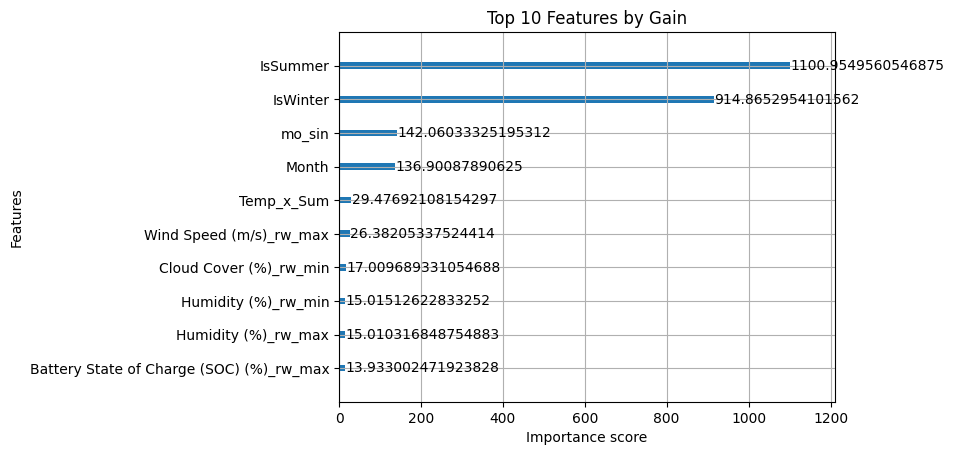

In [ ]:

# 1. Access the best model from your RandomSearch
best_model = random_search.best_estimator_

# 2. Plot importance based on 'Gain'
# This is usually more reliable than the default 'Weight'
xgb.plot_importance(best_model, importance_type='gain', max_num_features=10)
plt.title("Top 10 Features by Gain")
plt.show()

## Resume Here

### Hyperparameter Tuning

In [ ]:
def objective(trial):
    # 1. Define the search space
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "random_state": 42,
        "eval_metric": "rmse" # eval_metric is part of params for xgb.train
    }

    # 3. Initialize the Pruning Callback
    pruning_callback = XGBoostPruningCallback(trial, "validation_0-rmse")

    # 4. Train the model using xgb.train (native API) instead of XGBRegressor.fit (scikit-learn API)
    # Use globally defined dtrain and dval DMatrices
    model = xgb.train(
        param,
        dtrain,
        num_boost_round=2000, # Use num_boost_round for xgb.train
        evals=[(dval, "validation_0")],
        callbacks=[pruning_callback],
        verbose_eval=False # Suppress verbose output for cleaner logs during tuning
    )

    # 5. Return the final score
    # Use model.predict with the dval DMatrix
    preds = model.predict(dval)
    mse = mean_squared_error(y_val, preds)
    rmse = np.sqrt(mse)
    return rmse

In [ ]:
# --- RUNNING THE STUDY ---
study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.MedianPruner() # Kills trials below the median performance
)
# Call objective without X, y arguments as dtrain and dval are used globally
study.optimize(objective, n_trials=10)

print(f"Best Trial: {study.best_trial.params}")

[I 2026-01-27 21:05:57,469] A new study created in memory with name: no-name-2605ca4a-e0ec-40bb-8c4c-08f5c52b372e
[I 2026-01-27 21:07:44,737] Trial 0 finished with value: 286.2939484587185 and parameters: {'learning_rate': 0.08291623830245279, 'max_depth': 8, 'subsample': 0.8250870868685038, 'colsample_bytree': 0.5434031522911896, 'gamma': 6.939631272909e-07}. Best is trial 0 with value: 286.2939484587185.
[I 2026-01-27 21:08:14,490] Trial 1 finished with value: 278.2190215928924 and parameters: {'learning_rate': 0.02940421223987397, 'max_depth': 3, 'subsample': 0.7640449779981262, 'colsample_bytree': 0.9395094187799329, 'gamma': 2.334795334191056e-05}. Best is trial 1 with value: 278.2190215928924.
[I 2026-01-27 21:11:05,026] Trial 2 finished with value: 283.9599066709507 and parameters: {'learning_rate': 0.03574856180223207, 'max_depth': 9, 'subsample': 0.5249596990930787, 'colsample_bytree': 0.547229108346899, 'gamma': 0.01415877520081583}. Best is trial 1 with value: 278.2190215928

Best Trial: {'learning_rate': 0.0018284917142402206, 'max_depth': 10, 'subsample': 0.9974351407010842, 'colsample_bytree': 0.7967419196974217, 'gamma': 2.053178773240023e-07}
